In [162]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import powerlaw
import matplotlib.pyplot as plt 

In [163]:
# Read files
actes = ['13','14','15','18','20','21','22','23','24']
df = pd.read_csv('GJacte13.csv')
df['acte'] = [13]*len(df)
for acte in actes[1:]:
    dfi = pd.read_csv('GJacte'+acte+'.csv')
    dfi['acte'] = [int(acte)]*len(dfi)
    df = pd.concat([df,dfi],ignore_index=True)

C:\Users\Felipe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [164]:
# There are no retweets
df.is_retweet.value_counts()
#df.is_quote.value_counts()

False    163373
Name: is_retweet, dtype: int64

### Try to eliminate troll accounts

In [165]:
df = df[~df['screen_name'].str.contains('[Tt]roll')]
df = df[~df['screen_name'].str.contains('tv|TV|radio|journaux')]
df = df[df['followers_count'] > 0]
df = df[df['friends_count'] > 0]

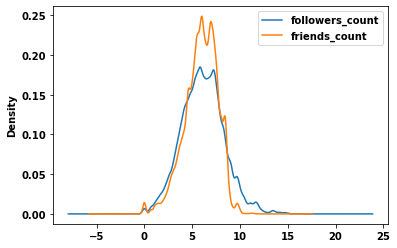

In [166]:
df[['followers_count','friends_count']].apply(np.log).plot.kde();

In [167]:
q = [0.1,0.25,0.5,0.75,0.9,0.95,0.99,0.999]
df[['followers_count','friends_count']].apply(np.log).quantile(q)

,followers_count,friends_count
0.100,3.332205,3.663562
0.250,4.605170,4.897840
0.500,6.075346,6.061457
0.750,7.499977,7.158514
0.900,8.842893,8.026497
0.950,9.793673,8.465310
0.990,11.819417,9.157045
0.999,14.525414,10.076180


In [168]:
print(df[['screen_name','followers_count']].sort_values('followers_count',ascending = False))
print(df[['screen_name','friends_count']].sort_values('friends_count',ascending = False))

        screen_name  followers_count
161898    lemondefr          8182478
161896    lemondefr          8182478
161897    lemondefr          8182478
146365    lemondefr          8170396
129052    lemondefr          8152760
...             ...              ...
78500   Halya_Iriss                1
78499   Halya_Iriss                1
78498   Halya_Iriss                1
3235      horloge31                1
162523  HectorZabor                1

[158913 rows x 2 columns]
           screen_name  friends_count
33375   WilliamOmbagho         124936
76873   WilliamOmbagho         124335
82405   WilliamOmbagho         124004
89855   IndigndeVerdad         117544
89860   IndigndeVerdad         117544
...                ...            ...
24757      KairosNeige              1
162731    singenhiver1              1
162732    singenhiver1              1
24756      KairosNeige              1
95201     Yvon_Mbaiser              1

[158913 rows x 2 columns]


In [169]:
q1 = df['followers_count'].apply(np.log).quantile(0.99)
q2 = df['friends_count'].apply(np.log).quantile(0.99)

df = df[np.logical_and(df['followers_count'].apply(np.log) < q1,df['friends_count'].apply(np.log) < q2)]
len(df)

155727

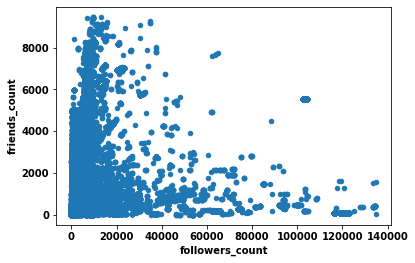

In [170]:
df.plot.scatter('followers_count','friends_count');

###  Prepare hashtags and mentioned users

In [171]:
def prep_list_text(x):
    if pd.isnull(x):
        pass
    else:
        # replace some characters
        x = re.sub("c\(","",x)
        x = re.sub("\)","",x)
        x = re.sub("\"","",x)
        # to lower case
        x = x.lower()
        return(x)


df['hashtags'] = df['hashtags'].apply(lambda x: prep_list_text(x))
df['mentions_screen_name'] = df['mentions_screen_name'].apply(lambda x: prep_list_text(x))

### Hashtags and mentioned users to edge list

In [172]:
import re
from itertools import combinations 

# Given a list of hashtags, it generates a list of all possible links.
def hashtag2list(x):
    x = x.split(", ")
    if len(x)>1:
        return([i for i in combinations(x,2)])
    else:
        pass

# Given a user and list of mentioned users, it generates a list of all possible links.
# s: source user
# t: mentioned users

def users2list(s,t):
    if pd.isnull(t):
        pass
    else:
        t = t.split(", ")
        return([(s,i) for i in t])

### Create edge lists (t <= t')

In [173]:
import copy

# Edge
ht_edgelists = {}
hashtags_edgelist = []
for acte in df.acte.unique():
    for x in df.hashtags[df.acte == acte].values:
        ht = hashtag2list(x)
        if ht is not None:
            hashtags_edgelist += ht
    ht_edgelists[acte] = copy.deepcopy(hashtags_edgelist)
            
users_edgelists = {}
users_edgelist = []        
for acte in df.acte.unique():
    for k in list(df[df.acte == acte].index):        
        u = users2list(df['screen_name'].loc[k], df['mentions_screen_name'].loc[k])
        if u is not None:
            users_edgelist += u 
    users_edgelists[acte] = copy.deepcopy(users_edgelist)

In [174]:
print([len(i) for i in ht_edgelists.values()])
print([len(i) for i in users_edgelists.values()])


[174927, 260883, 369658, 473089, 600477, 731055, 862793, 968880, 1087465]
[31584, 36566, 52372, 65868, 82429, 99042, 115793, 130737, 146134]


In [176]:
for v in list(ht_edgelists.keys()):
    ht_edgelists[v] = pd.value_counts(ht_edgelists[v])
    users_edgelists[v] = pd.value_counts(users_edgelists[v])

In [177]:
print([len(i) for i in ht_edgelists.values()])
print([len(i) for i in users_edgelists.values()])

[61785, 66915, 98805, 123971, 155850, 185971, 218556, 244205, 275080]
[24439, 25841, 36677, 45991, 56075, 65930, 75665, 84641, 93148]


# Networks of Mentioned Users

In [178]:
# Weighted directed networks
gs = {}
for i,v in users_edgelists.items():
    g = nx.DiGraph() # users
    g.add_weighted_edges_from([tuple(list(v.index[k])+[v.iloc[k]]) for k in range(len(v))])
    gs[i] = g

In [179]:
print('Are the networks weakly connected?', [nx.is_weakly_connected(g) for g in gs.values()])
print('Sizes of the 5 largest weakly connected components:\n', 
      [[len(c) for c in sorted(nx.weakly_connected_components(g),key=len, reverse=True)][:5] for g in gs.values()])
print('Sizes of the 5 largest strongly connected components:\n', 
      [[len(c) for c in sorted(nx.strongly_connected_components(g),key=len, reverse=True)][:5] for g in gs.values()])

Are the networks weakly connected? [False, False, False, False, False, False, False, False, False]
Sizes of the 5 largest weakly connected components:
 [[11263, 14, 12, 10, 9], [11721, 14, 12, 10, 9], [15315, 16, 10, 9, 8], [18313, 16, 11, 10, 9], [21142, 51, 16, 11, 10], [23790, 51, 16, 11, 10], [26106, 51, 16, 11, 10], [28165, 51, 16, 11, 11], [30054, 51, 16, 11, 10]]
Sizes of the 5 largest strongly connected components:
 [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [4, 2, 2, 2, 2], [4, 2, 2, 2, 2], [4, 4, 2, 2, 2], [9, 5, 2, 2, 2], [22, 6, 3, 2, 2], [22, 7, 3, 2, 2], [33, 3, 2, 2, 2]]


In [180]:
### Keep the largest weakly connected component
for i,v in gs.items():
    gs[i] = v.subgraph(max(nx.weakly_connected_components(v), key=len))    

### Evolution of the system size (relative to the final size)

In [560]:
print([len(g.nodes()) for g in gs.values()])
print([len(g.edges()) for g in gs.values()])

[11263, 11721, 15315, 18313, 21142, 23790, 26106, 28165, 30054]
[23831, 25215, 35979, 45230, 55167, 64971, 74664, 83608, 92085]


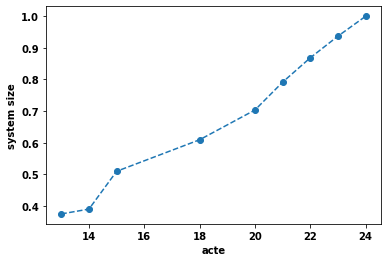

In [181]:
# Plot system size 
g_size = np.array([len(g) for g in gs.values()])
plt.plot(list(gs.keys()), 1/g_size[-1]*g_size,'--o')
plt.xlabel('acte')
plt.ylabel('system size');

### Plotting the CCDF of the degree distribution and strength distribution in log-log scale.

In [182]:
k_in = {}
k_out = {}
s_in = {}
s_out = {}

for i,v in gs.items():
    k_in[i] = [i[1] for i in list(v.in_degree())] # in-degree
    k_out[i] = [i[1] for i in list(v.out_degree())] # out-degree
    s_in[i] = [i[1] for i in list(v.in_degree(weight = 'weight'))] # in-strength
    s_out[i] = [i[1] for i in list(v.out_degree(weight = 'weight'))] # out-strength

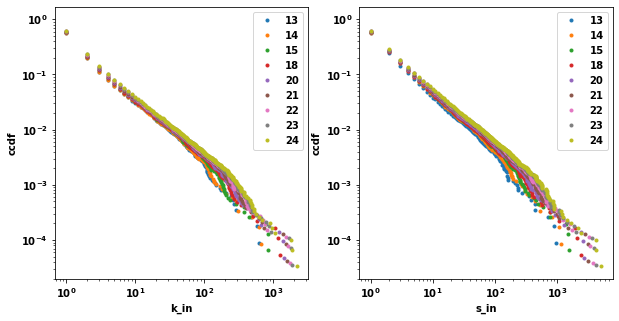

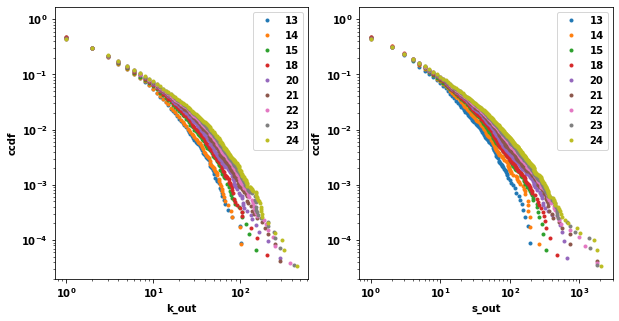

In [183]:
fig1, ax = plt.subplots(1, 2, figsize = (10, 5)) 
for i in k_in.keys():
    powerlaw.plot_ccdf(k_in[i], linestyle="", marker=".", ax = ax[0], label = i)
    ax[0].set_ylabel(u"ccdf")
    ax[0].set_xlabel(r"k_in")
    ax[0].legend();

    powerlaw.plot_ccdf(s_in[i], linestyle="",marker=".", ax = ax[1], label = i)
    ax[1].set_ylabel(u"ccdf")
    ax[1].set_xlabel(r"s_in")
    ax[1].legend();

fig2, ax = plt.subplots(1, 2, figsize = (10, 5)) 
for i in k_in.keys():
    powerlaw.plot_ccdf(k_out[i], linestyle="", marker=".", ax = ax[0], label = i)
    ax[0].set_ylabel(u"ccdf")
    ax[0].set_xlabel(r"k_out")
    ax[0].legend();

    powerlaw.plot_ccdf(s_out[i], linestyle="",marker=".", ax = ax[1], label = i)
    ax[1].set_ylabel(u"ccdf")
    ax[1].set_xlabel(r"s_out")
    ax[1].legend();    

In [184]:
res_fit = pd.DataFrame(gs.keys(), columns = ['acte'])
res_fit_in = [powerlaw.Fit(x, discrete=True) for x in s_in.values()]
res_fit['alpha_s_in'] = [round(x.alpha, 3) for x in res_fit_in]
res_fit['sigma_s_in'] = [round(x.sigma, 3) for x in res_fit_in]

res_fit_out = [powerlaw.Fit(x, discrete=True) for x in s_out.values()]
res_fit['alpha_s_out'] = [round(x.alpha, 3) for x in res_fit_out]
res_fit['sigma_s_out'] = [round(x.sigma, 3) for x in res_fit_out]

print(res_fit)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\Felipe\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\Users\Felipe\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or ne

   acte  alpha_s_in  sigma_s_in  alpha_s_out  sigma_s_out
0    13       1.977       0.024        2.566        0.066
1    14       1.978       0.023        2.489        0.064
2    15       1.996       0.023        2.843        0.113
3    18       1.964       0.024        2.979        0.133
4    20       1.953       0.019        2.797        0.108
5    21       1.942       0.017        2.100        0.024
6    22       1.933       0.016        2.666        0.095
7    23       1.927       0.015        2.577        0.076
8    24       1.909       0.012        2.512        0.069


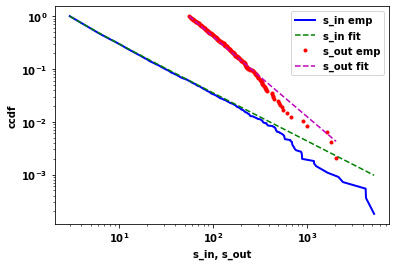

In [185]:
fig04 = res_fit_in[-1].plot_ccdf(color='b', linewidth=2, label = 's_in emp')
res_fit_in[-1].power_law.plot_ccdf(color='g', linestyle='--', ax=fig04, label = 's_in fit')
res_fit_out[-1].plot_ccdf(color='r', linestyle="",marker=".", label = 's_out emp')
res_fit_out[-1].power_law.plot_ccdf(color='m', linestyle='--', ax=fig04, label = 's_out fit')

fig04.set_ylabel(u"ccdf")
fig04.set_xlabel(r"s_in, s_out")
fig04.legend();

### Goodness of fit

In [186]:
def get_pval(nsim,v,fit):
    Ds_simulated = [None]*nsim # list of synthetic KS statistics
    v_head = np.array([v[i] for i in range(len(v)) if v[i] < int(fit.xmin)])

    for k in range(nsim):
        theoretical_distribution = powerlaw.Power_Law(xmin=fit.xmin, parameters=[fit.alpha])
        simulated_v = theoretical_distribution.generate_random(round(fit.n_tail)) # simulated tail v
        simulated_v = np.append(v_head, simulated_v) # put together simulated tail with real head
        fit_simulated = powerlaw.Fit(simulated_v, verbose=True)
        Ds_simulated[k] = fit_simulated.D
    Ds_simulated = np.array(Ds_simulated)
    pval = len(Ds_simulated[Ds_simulated > fit.D]) / len(Ds_simulated)
    return(pval)

In [173]:
nsim = 100 # number of synthetic k_in sets

pval_in = []
pval_out = []
for i,e in enumerate(list(s_in.keys())):
    pval_in.append(get_pval(nsim,s_in[e],res_fit_in[i]))
    pval_out.append(get_pval(nsim,s_out[e],res_fit_in[i]))   
    
res_fit['pval_in'] = pval_in    
res_fit['pval_out'] = pval_out    

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

In [179]:
res_fit.round(3)    

,acte,alpha_s_in,sigma_s_in,alpha_s_out,sigma_s_out,pval_in,pval_out,R_ln_in,p_ln_in,R_exp_in,p_exp_in,R_ln_out,p_ln_out,R_exp_out,p_exp_out
0,13,1.977,0.024,2.566,0.066,0.91,0.96,-1.825,0.185,984.535,0.0,-5.275,0.034,42.006,0.002
1,14,1.978,0.023,2.489,0.064,0.49,0.61,-1.255,0.253,1213.972,0.0,-7.971,0.012,35.873,0.010
2,15,1.996,0.023,2.843,0.113,0.33,0.40,-0.426,0.366,1263.469,0.0,-0.977,0.326,19.375,0.006
3,18,1.964,0.024,2.979,0.133,0.92,0.92,-0.979,0.342,1155.813,0.0,-0.186,0.652,20.594,0.002
4,20,1.953,0.019,2.797,0.108,0.98,0.99,-0.818,0.328,2005.262,0.0,-0.132,0.713,36.526,0.000
5,21,1.942,0.017,2.100,0.024,0.80,0.79,-0.916,0.298,2413.886,0.0,-34.893,0.000,408.464,0.000
6,22,1.933,0.016,2.666,0.095,0.99,1.00,-1.313,0.270,2827.749,0.0,-0.499,0.559,47.781,0.008
7,23,1.927,0.015,2.577,0.076,0.94,0.97,-1.270,0.265,3214.906,0.0,-1.219,0.374,69.558,0.002
8,24,1.909,0.012,2.512,0.069,0.34,0.47,-2.366,0.176,5179.803,0.0,-2.449,0.229,75.796,0.004


The power law hypothesis cannot be rejected.

### Fitting alternative distributions, and comparing their fit with the power law fit

In [187]:
def res_compare(myfit, alternative = 'lognormal'):    
    R,p = myfit.distribution_compare('power_law', alternative)
    return([R,p])

res_fit[['R_ln_in','p_ln_in']] = pd.DataFrame([res_compare(i) for i in res_fit_in]).round(3)   
res_fit[['R_exp_in','p_exp_in']] = pd.DataFrame([res_compare(i, alternative = 'exponential') for i in res_fit_in]).round(3)
res_fit[['R_ln_out','p_ln_out']] = pd.DataFrame([res_compare(i) for i in res_fit_out]).round(3)
res_fit[['R_exp_out','p_exp_out']] = pd.DataFrame([res_compare(i, alternative = 'exponential') for i in res_fit_out]).round(3)


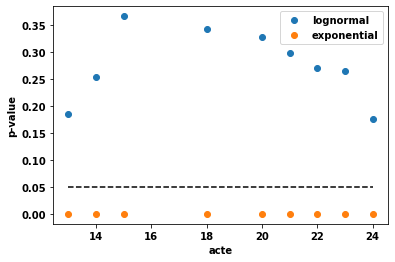

In [188]:
plt.plot(res_fit['acte'], res_fit['p_ln_in'], 'o', label = 'lognormal')
plt.plot(res_fit['acte'], res_fit['p_exp_in'],'o', label = 'exponential')
plt.hlines(0.05, xmin = min(res_fit['acte']), xmax = max(res_fit['acte']), linestyle="--")
plt.xlabel('acte')
plt.ylabel('p-value')
plt.legend();

We cannot reject the hypotheses that lognormal and exponential fits are equally likely than power law fit. Nevertheless, we note that the estimated mean is negative for the lognormal distribution and close to zero for the exponential distribution.

In [189]:
print('Parameters of the lognormal distribution: ')
print("mu: " + str(round(res_fit_in[-1].lognormal.mu, 3)))
print("sigma: " + str(round(res_fit_in[-1].lognormal.sigma, 3)))

print('Parameters of the exponential distribution: ')
print("lambda: " + str(round(res_fit_in[-1].exponential.Lambda, 3)))

Parameters of the lognormal distribution: 
mu: -31.897
sigma: 6.171
Parameters of the exponential distribution: 
lambda: 0.048


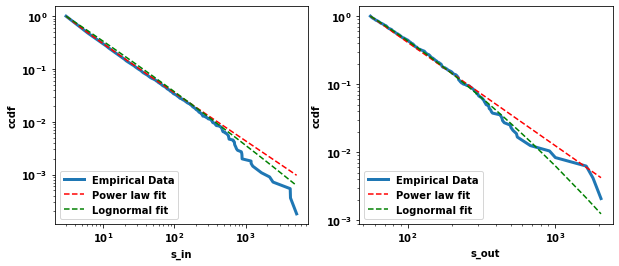

In [190]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
res_fit_in[-1].plot_ccdf(ax= ax[0], linewidth=3, label='Empirical Data')
res_fit_in[-1].power_law.plot_ccdf(ax=ax[0], color='r', linestyle='--', label='Power law fit')
res_fit_in[-1].lognormal.plot_ccdf(ax=ax[0], color='g', linestyle='--', label='Lognormal fit')

ax[0].set_ylabel(u"ccdf")
ax[0].set_xlabel("s_in")
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc=3);

res_fit_out[-1].plot_ccdf(ax= ax[1], linewidth=3, label='Empirical Data')
res_fit_out[-1].power_law.plot_ccdf(ax=ax[1], color='r', linestyle='--', label='Power law fit')
res_fit_out[-1].lognormal.plot_ccdf(ax=ax[1], color='g', linestyle='--', label='Lognormal fit')

ax[1].set_ylabel(u"ccdf")
ax[1].set_xlabel("s_out")
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels, loc=3);

### Is there burstiness in mentions?

Mention dynamics

In [191]:
# Strengths with keys
s_in_ = {}
s_out_ = {}

for i,v in gs.items():
    s_in_[i] = dict(v.in_degree(weight = 'weight')) # in-strength
    s_out_[i] = dict(v.out_degree(weight = 'weight')) # out-strength

In [192]:
# Sort nodes with k-largest in/out-strength when the whole system is built up
d_s_in = list(gs[max(gs.keys())].in_degree(weight = 'weight'))
d_s_out = list(gs[max(gs.keys())].out_degree(weight = 'weight'))
d_s_in = sorted(d_s_in, key = lambda x: x[1], reverse = True)
d_s_out = sorted(d_s_out, key = lambda x: x[1], reverse = True)    

In [193]:
# Get strength of user along different periods
def get_user_strength(user, get_in = True):
    if get_in:
        x = [v[user] if user in v.keys() else 0 for v in s_in_.values()]
    else:
        x = [v[user] if user in v.keys() else 0 for v in s_out_.values()]
    return(np.array(x))

# Get logarithmic derivative
def log_deriv(user_strength):
    a = np.divide(np.diff(user_strength),user_strength[:-1])
    a[np.logical_or(a == np.inf,  a == -np.inf)] = None
    return(a)

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


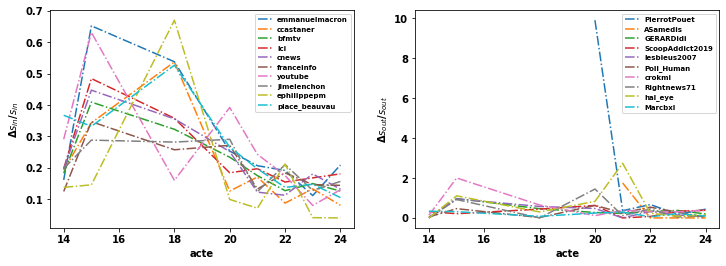

In [194]:
# Plot the logarithmic derivative
k = 10

fig, ax = plt.subplots(1,2, figsize = (12,4)) 
for user in [x[0] for x in d_s_in][:k]:
    ax[0].plot(list(s_in_.keys())[1:],log_deriv(get_user_strength(user)), linestyle = '-.', label = user)

ax[0].set_xlabel('acte')
ax[0].set_ylabel(r'$\Delta s_{in}/s_{in}$')
ax[0].legend(fontsize=7)

for user in [x[0] for x in d_s_out][:k]:
    ax[1].plot(list(s_out_.keys())[1:],log_deriv(get_user_strength(user, get_in = False)), linestyle = '-.', label = user)

ax[1].set_xlabel('acte')
ax[1].set_ylabel(r'$\Delta s_{out}/s_{out}$')
ax[1].legend(fontsize=7);

Burst size distribution

In [195]:
# Get average logartithmic derivatives of s_in and s_out for all users
av_ld_users_s_in = []
av_ld_users_s_out = []
for user in list(gs[max(gs.keys())].nodes()):
    y_in = log_deriv(get_user_strength(user))
    y_out = log_deriv(get_user_strength(user, get_in = False))
    av_ld_users_s_in.append(np.nanmean([i for i in y_in if i is not None]))
    av_ld_users_s_out.append(np.nanmean([i for i in y_out if i is not None]))

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Values less than or equal to 0 in data. Throwing out 0 or negative values
C:\Users\Felipe\Anaconda3\lib\site-packages\powerlaw.py:101: RuntimeWarning: invalid value encountered in greater
  self.data = self.data[self.data>0]
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


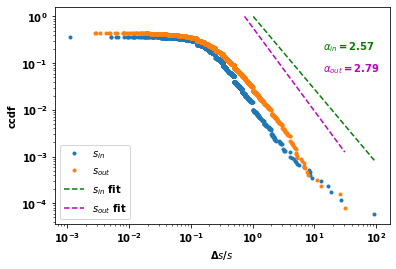

In [196]:
fig1, ax = plt.subplots(1, 1) 
powerlaw.plot_ccdf([x for x in av_ld_users_s_in if np.isfinite(x)], linestyle="", marker=".", ax = ax, label = r"$s_{in}$")
powerlaw.plot_ccdf([x for x in av_ld_users_s_out if np.isfinite(x)], linestyle="", marker=".", ax = ax, label = r"$s_{out}$")
# add fitted curves
f_in = powerlaw.Fit(av_ld_users_s_in)
f_out = powerlaw.Fit(av_ld_users_s_out)
f_in.power_law.plot_ccdf(color='g', linestyle='--', ax = ax, label = r'$s_{in}$ fit')
f_out.power_law.plot_ccdf(color='m', linestyle='--', ax = ax, label = r'$s_{out}$ fit')
# add fitted values of exponents
ax.text(.8,.8,r"$\alpha_{in} = $"+str(np.round(f_in.alpha, 2)), color='g', transform=ax.transAxes)
ax.text(.8,.7,r"$\alpha_{out} = $"+str(np.round(f_out.alpha, 2)), color='m', transform=ax.transAxes)


ax.set_ylabel(u"ccdf")
ax.set_xlabel(r'$\Delta s/s$')
ax.legend(loc = 'lower left');

### Rank model function

In [548]:
from itertools import permutations
def rank_model_age(n, m, alpha,periods):
    g = nx.DiGraph()
    g.add_edges_from(list(permutations(range(m), 2)))
    rank_s_in = {}
    
    age = list(range(1,n+1))    
    num_attractiveness = np.array([t**(-alpha) for t in age]) # numerator
    for t in range(m,n):
        attractiveness = num_attractiveness[:(t)]/np.sum(num_attractiveness[:(t)])
        new_edges = [(t,x) for x in np.random.choice(len(attractiveness), size=m, replace=False, p=attractiveness)]
        g.add_edges_from(new_edges)
        if t+1 in periods:
            rank_s_in[t] = dict(g.in_degree())
    return(rank_s_in)

def rank_model_k(n, m, alpha,periods):
    g = nx.DiGraph()
    g.add_edges_from(list(permutations(range(m), 2)))
    rank_s_in = {}            
    # degree is used as rank        
    for t in range(m,n):
        num_attractiveness = np.array([i[1]**(-alpha) for i in list(g.degree())]) # numerator
        attractiveness = num_attractiveness/np.sum(num_attractiveness)
        new_edges = [(t,x) for x in np.random.choice(len(attractiveness), size=m, replace=False, p=attractiveness)]
        g.add_edges_from(new_edges)
        if t+1 in periods:
            rank_s_in[t] = dict(g.in_degree())

    return(rank_s_in)

In [541]:
#rank_model_k(50, 3, 0.98,[15,20,21,46])

In [518]:
# In-degrees for empirical networks
res_k_in = {}
for i,v in gs.items():
    res_k_in[i] = dict(v.in_degree())

# Get logartithmic derivatives of k_in for all users
emp_av_ld_users_k_in = [] # average over all existing periods
emp_av_ld_users_k_in_last = [] # average on the last period
emp_ld_users_k_in = [] 
for user in list(gs[max(gs.keys())].nodes()):
    y_in_emp = log_deriv([v[user] if user in v.keys() else 0 for v in res_k_in.values()])
    emp_av_ld_users_k_in.append(np.nanmean([i for i in y_in_emp if i is not None]))    
    emp_av_ld_users_k_in_last.append(y_in_emp[-1])
    emp_ld_users_k_in += [i for i in y_in_emp if i is not None] # all non null values 

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [519]:
res_fit_k_in = [powerlaw.Fit(x, discrete=True) for x in [list(v.values()) for v in res_k_in.values()]]
print([round(x.alpha, 3) for x in res_fit_k_in])
print([round(x.sigma, 3) for x in res_fit_k_in])

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\Felipe\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\Users\Felipe\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or ne

[1.991, 1.98, 1.983, 1.971, 1.968, 1.981, 1.976, 1.97, 1.97]
[0.033, 0.032, 0.023, 0.021, 0.022, 0.021, 0.019, 0.018, 0.017]


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [545]:
fit_ld = powerlaw.Fit(emp_ld_users_k_in, discrete=False)
print("alpha:", round(fit_ld.alpha, 3), "; sigma: ", round(fit_ld.sigma, 3))

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


alpha: 3.208 ; sigma:  0.295


### Run model and plot

In [581]:
def res_sim(res_rank_model, include_pdf = False):     
    # Get logartithmic derivatives of k_in for all users
    sim_av_ld_users_k_in = [] # average over all existing periods
    sim_av_ld_users_k_in_last = [] # average on the last period
    sim_ld_users_k_in = [] # all non null values 

    for user in range(n):
        y_in_sim = log_deriv([v[user] if user in v.keys() else 0 for v in res_rank_model.values()])
        sim_av_ld_users_k_in.append(np.nanmean([i for i in y_in_sim if i is not None]))    
        sim_av_ld_users_k_in_last.append(y_in_sim[-1])
        sim_ld_users_k_in += [i for i in y_in_sim if i is not None]
    
    if include_pdf:
        fig1, ax = plt.subplots(1, 2, figsize = (15,5)) 
        powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
        powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$")        
        ax[0].set_ylabel(u"ccdf")
        ax[0].set_xlabel(r'$\Delta k/k$')
        ax[0].legend();

        powerlaw.plot_pdf([x for x in emp_av_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
        powerlaw.plot_pdf([x for x in sim_av_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
        ax[1].set_ylabel(u"pdf")
        ax[1].set_xlabel(r'$\Delta k/k$')
        ax[1].legend();        

        fig2, ax = plt.subplots(1, 2, figsize = (15,5)) 
        powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
        powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
        ax[0].set_ylabel(u"ccdf")
        ax[0].set_xlabel(r'$\Delta k/k$')
        ax[0].legend();

        powerlaw.plot_pdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
        powerlaw.plot_pdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
        ax[1].set_ylabel(u"pdf")
        ax[1].set_xlabel(r'$\Delta k/k$')
        ax[1].legend();        

        fig3, ax = plt.subplots(1, 2, figsize = (15,5)) 
        powerlaw.plot_ccdf([x for x in emp_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
        powerlaw.plot_ccdf([x for x in sim_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
        ax[0].set_ylabel(u"ccdf")
        ax[0].set_xlabel(r'$\Delta k/k$')
        ax[0].legend();

        powerlaw.plot_pdf([x for x in emp_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
        powerlaw.plot_pdf([x for x in sim_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
        ax[1].set_ylabel(u"pdf")
        ax[1].set_xlabel(r'$\Delta k/k$')
        ax[1].legend();    
    
    else:
        fig1, ax = plt.subplots(1, 3, figsize = (15,5)) 
        powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
        powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$")        
        ax[0].set_ylabel(u"ccdf")
        ax[0].set_xlabel(r'$\Delta k/k$')
        ax[0].legend();

        powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
        powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[1], label = r"$sim$");
        ax[1].set_ylabel(u"ccdf")
        ax[1].set_xlabel(r'$\Delta k/k$')
        ax[1].legend();

        powerlaw.plot_ccdf([x for x in emp_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[2], label = r"$emp$")
        powerlaw.plot_ccdf([x for x in sim_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[2], label = r"$sim$");
        ax[2].set_ylabel(u"ccdf")
        ax[2].set_xlabel(r'$\Delta k/k$')
        ax[2].legend();

### Age as Rank

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


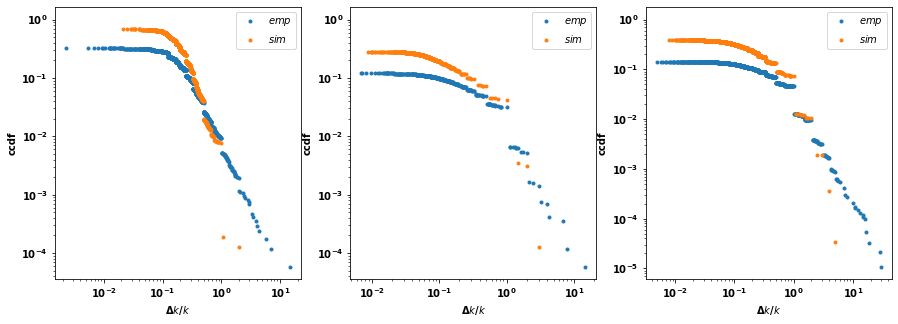

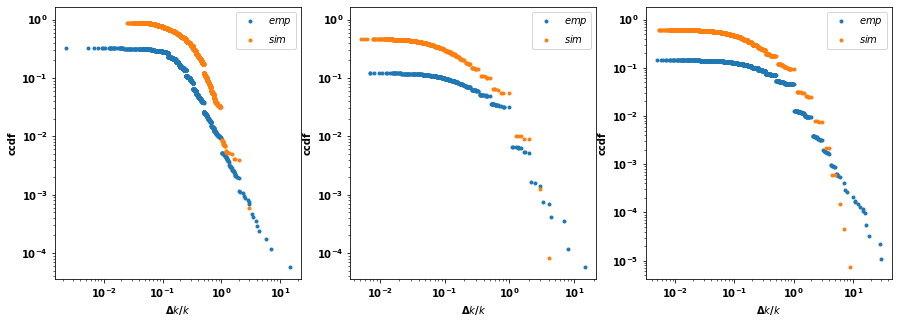

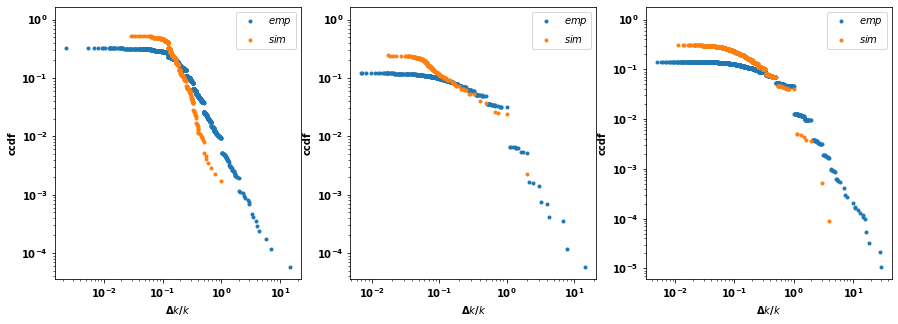

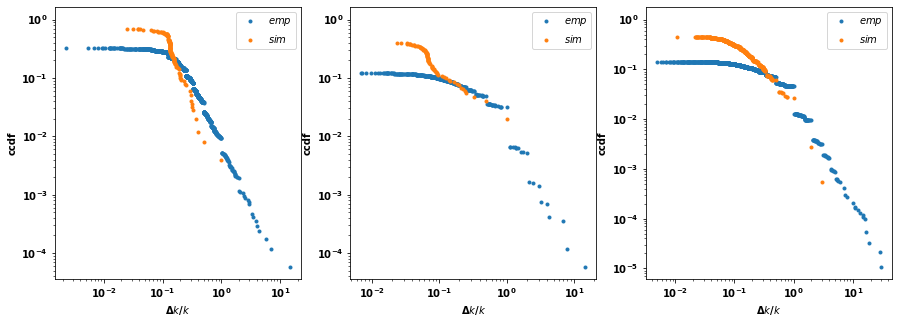

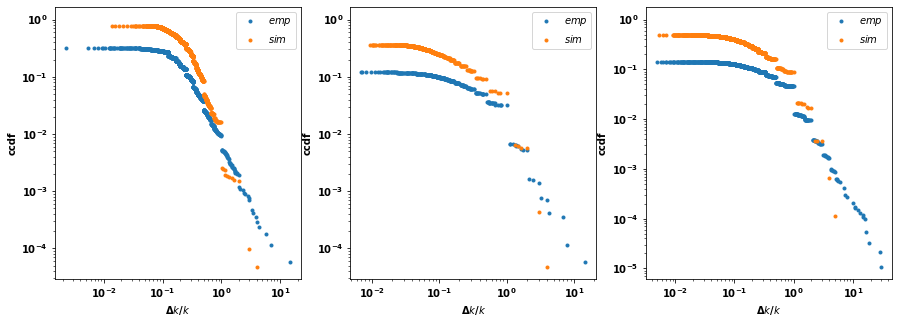

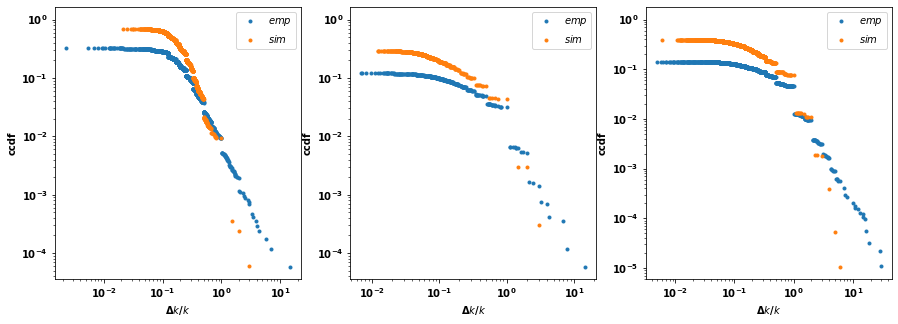

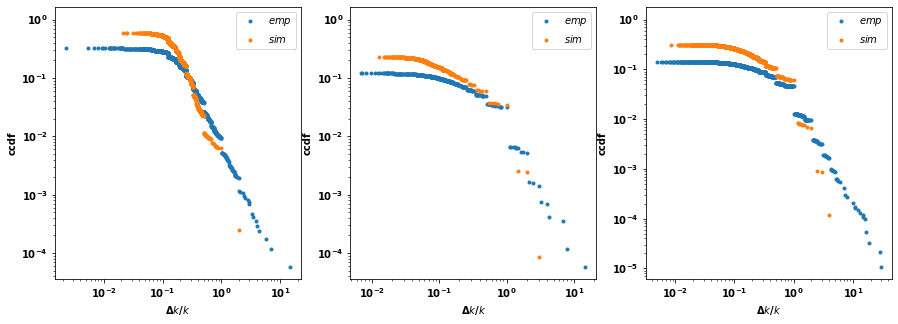

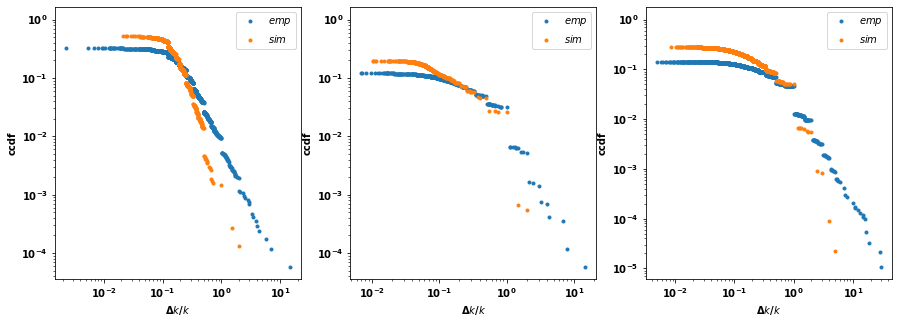

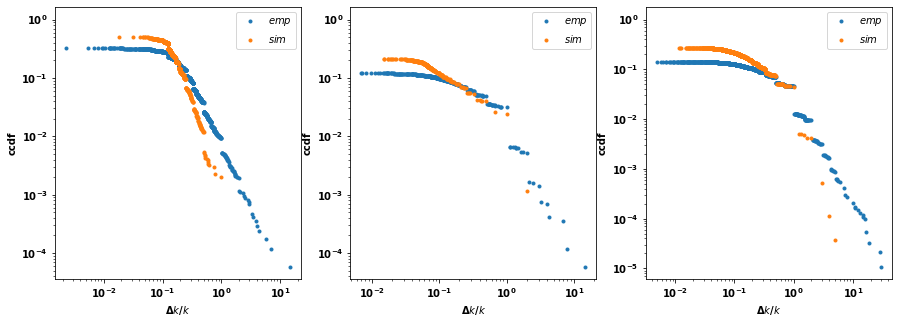

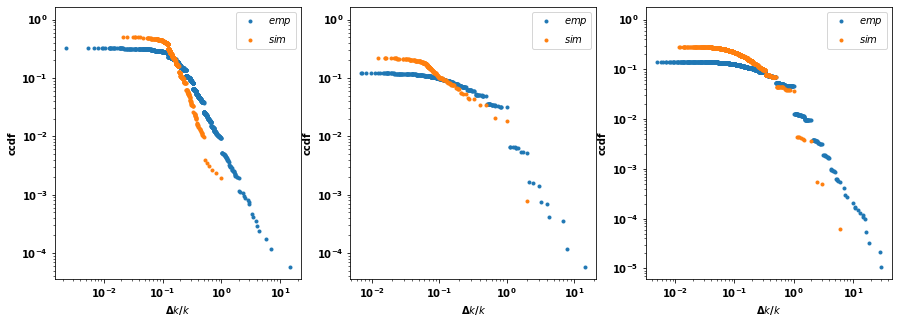

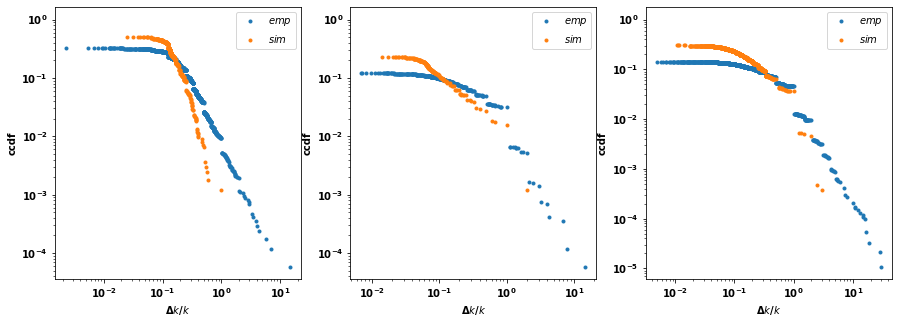

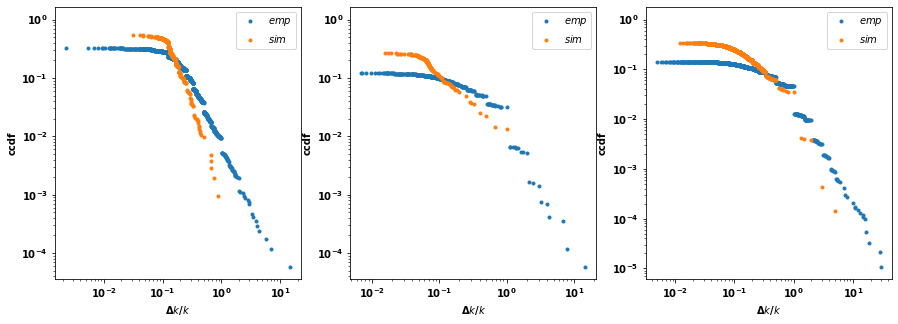

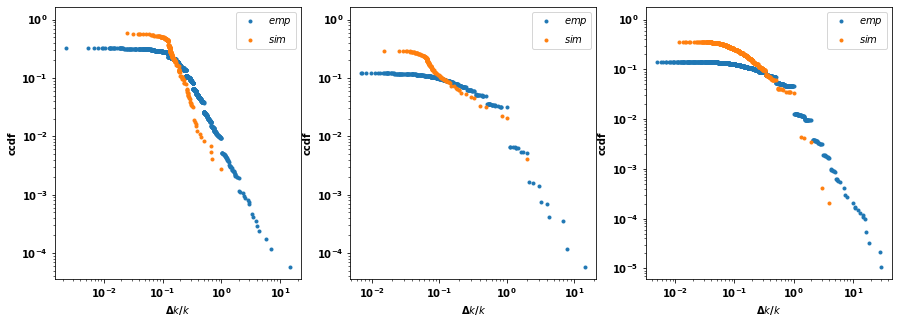

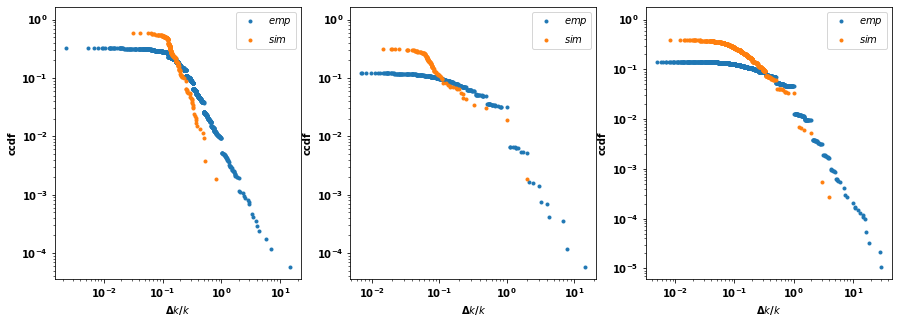

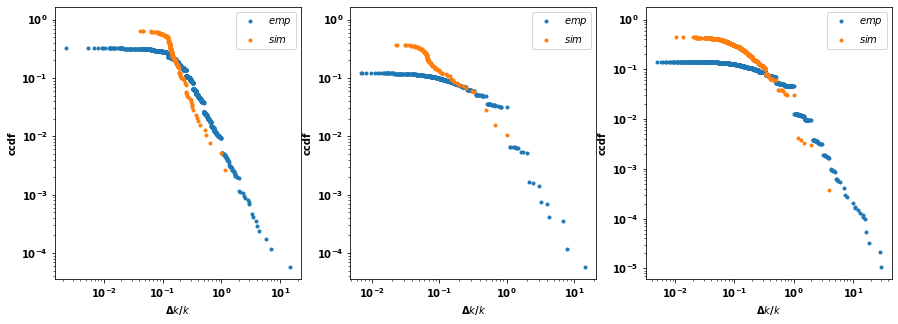

In [582]:
n = len(gs[max(gs.keys())])# number of nodes
m = 10 # number new links set from each new node to pre-existing nodes
alphas = [1/(1.97-1), 1/(3.208-1), 1.97, 3.208,]+list(np.arange(0.8,3,0.2))
periods = [len(h) for h in gs.values()] # size of networks, they indicate when a period ends
for alpha in alphas:
    res_rank_model = rank_model_age(n, m, alpha, periods)
    res_sim(res_rank_model)

### Degree as Rank

n = len(gs[max(gs.keys())])# number of nodes
m = 10 # number new links set from each new node to pre-existing nodes
alphas = [1/(1.97-1), 1/(3.208-1), 1.97, 3.208]+list(np.arange(0.8,3,0.2))
periods = [len(h) for h in gs.values()] # size of networks, they indicate when a period ends
for alpha in alphas:
    res_rank_model = rank_model_k(n, m, alpha, periods)
    res_sim(res_rank_model)

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


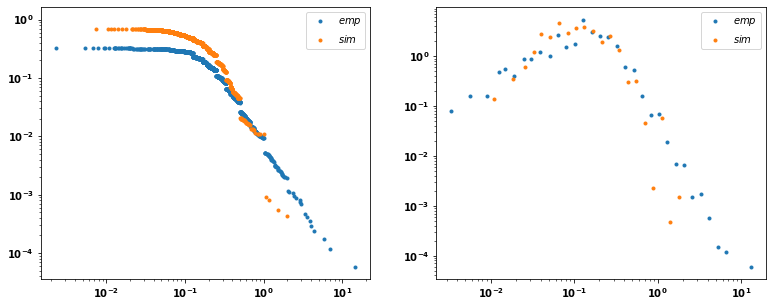

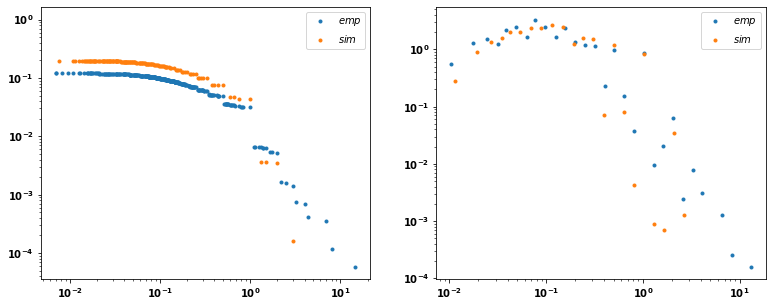

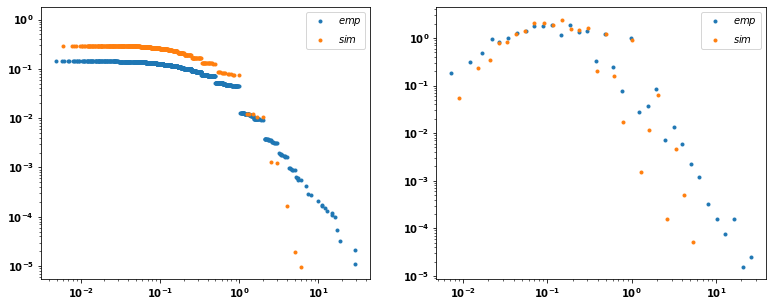

In [549]:
n = len(gs[max(gs.keys())])# number of nodes
m = 3 # number new links set from each new node to pre-existing nodes
alpha = 1/(3.208-1)
#1.5 #1/(1.97-1)
periods = [len(h) for h in gs.values()] # size of networks, they indicate when a period ends

# In-degrees for rank model
res_rank_model = rank_model_age(n, m, alpha, periods)

# Get logartithmic derivatives of k_in for all users
sim_av_ld_users_k_in = [] # average over all existing periods
sim_av_ld_users_k_in_last = [] # average on the last period
sim_ld_users_k_in = [] # all non null values 

for user in range(n):
    y_in_sim = log_deriv([v[user] if user in v.keys() else 0 for v in res_rank_model.values()])
    sim_av_ld_users_k_in.append(np.nanmean([i for i in y_in_sim if i is not None]))    
    sim_av_ld_users_k_in_last.append(y_in_sim[-1])
    sim_ld_users_k_in += [i for i in y_in_sim if i is not None]
    
fig1, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_av_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_av_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend();     

fig2, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend(); 

fig3, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend(); 

In [565]:
periods

[11263, 11721, 15315, 18313, 21142, 23790, 26106, 28165, 30054]

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


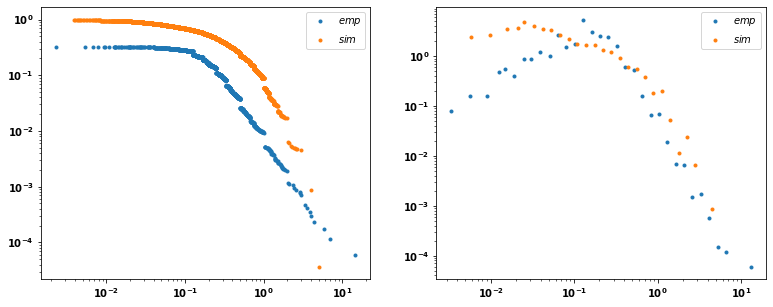

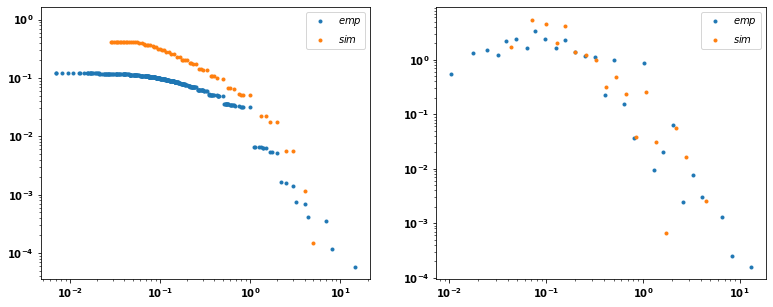

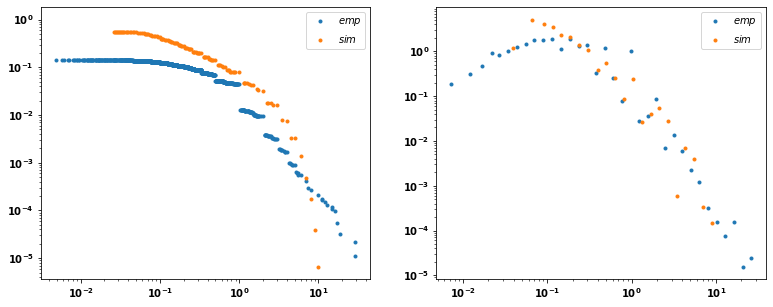

In [550]:
n = len(gs[max(gs.keys())])# number of nodes
m = 10 # number new links set from each new node to pre-existing nodes
#alpha = 1.97
alpha = 1/(1.97-1)
#alpha = 1/(3.208-1)
periods = [len(h) for h in gs.values()] # size of networks, they indicate when a period ends

# In-degrees for rank model
res_rank_model = rank_model_k(n, m, alpha, periods)

# Get logartithmic derivatives of k_in for all users
sim_av_ld_users_k_in = [] # average over all existing periods
sim_av_ld_users_k_in_last = [] # average on the last period
sim_ld_users_k_in = [] # all non null values 

for user in range(n):
    y_in_sim = log_deriv([v[user] if user in v.keys() else 0 for v in res_rank_model.values()])
    sim_av_ld_users_k_in.append(np.nanmean([i for i in y_in_sim if i is not None]))    
    sim_av_ld_users_k_in_last.append(y_in_sim[-1])
    sim_ld_users_k_in += [i for i in y_in_sim if i is not None]
    
fig1, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_av_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_av_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend();     

fig2, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend(); 

fig3, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend(); 

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


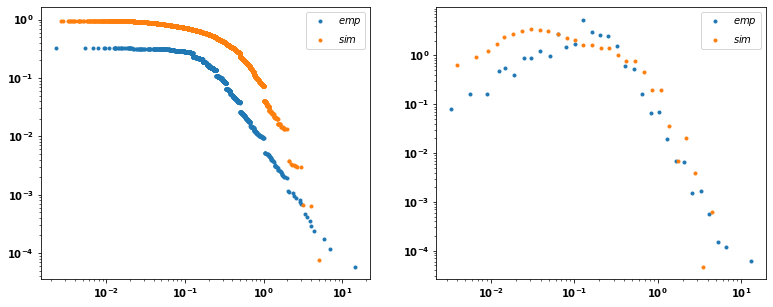

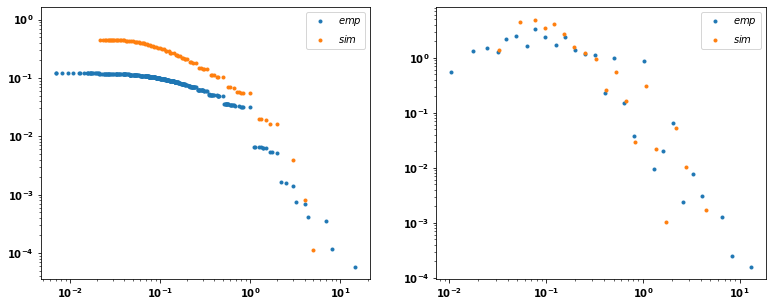

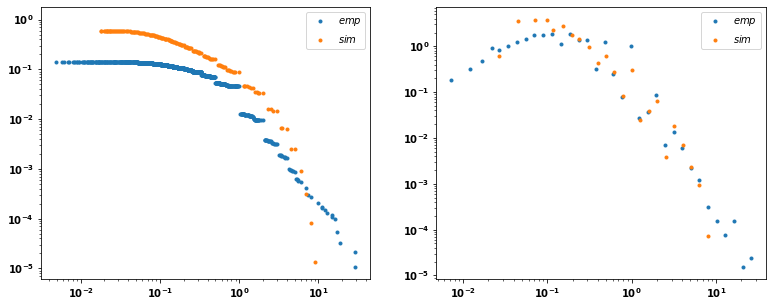

In [553]:
n = len(gs[max(gs.keys())])# number of nodes
m = 10 # number new links set from each new node to pre-existing nodes
#alpha = 1.97
alpha = 1/(1.97-1)
#alpha = 1/(3.208-1)
periods = [len(h) for h in gs.values()] # size of networks, they indicate when a period ends

# In-degrees for rank model
res_rank_model = rank_model_k(n, m, alpha, periods)

# Get logartithmic derivatives of k_in for all users
sim_av_ld_users_k_in = [] # average over all existing periods
sim_av_ld_users_k_in_last = [] # average on the last period
sim_ld_users_k_in = [] # all non null values 

for user in range(n):
    y_in_sim = log_deriv([v[user] if user in v.keys() else 0 for v in res_rank_model.values()])
    sim_av_ld_users_k_in.append(np.nanmean([i for i in y_in_sim if i is not None]))    
    sim_av_ld_users_k_in_last.append(y_in_sim[-1])
    sim_ld_users_k_in += [i for i in y_in_sim if i is not None]
    
fig1, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_av_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_av_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend();     

fig2, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_av_ld_users_k_in_last if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_av_ld_users_k_in_last if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend(); 

fig3, ax = plt.subplots(1, 2, figsize = (13,5)) 
powerlaw.plot_ccdf([x for x in emp_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$emp$")
powerlaw.plot_ccdf([x for x in sim_ld_users_k_in if np.isfinite(x)], linestyle="", marker=".", ax = ax[0], label = r"$sim$");
ax[0].legend()

powerlaw.plot_pdf([x for x in emp_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$emp$")
powerlaw.plot_pdf([x for x in sim_ld_users_k_in if np.isfinite(x) and x != 0], linestyle="", marker=".", ax = ax[1], label = r"$sim$")
ax[1].legend(); 

In [144]:
# Save edgelists of users network
for k in list(users_edgelists.keys()):
    fs = pd.DataFrame()
    fs['source'] = [i[0] for i in users_edgelists[k].index]
    fs['target'] = [i[1] for i in users_edgelists[k].index]
    fs['weight'] = users_edgelists[k].values
    fs.to_csv('edgelist'+str(k)+'.csv',index = False)

See Notebook Gilet_Jaunes2 for futher analysis (e.g., clustering and community structure). 

# Network of Hashtags

In [17]:
# Save edgelists of hashtags network:
for k in list(ht_edgelists.keys()):
    fs = pd.DataFrame()
    fs['source'] = [i[0] for i in ht_edgelists[k].index]
    fs['target'] = [i[1] for i in ht_edgelists[k].index]
    fs['weight'] = ht_edgelists[k].values
    fs.to_csv('ht_edgelist'+str(k)+'.csv',index = False)

See Notebook Gilet_Jaunes_ht1 for the corresponding analysis.